In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pysheds.grid import Grid
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pysheds.sview import ViewFinder, Raster

# values = np.arange(100, dtype='int8').reshape(10,10)
# view = ViewFinder(shape=values.shape, nodata=0)
# raster = Raster(values, view)

In [2]:
path = r"C:/Users/minh-nguyet.le/OneDrive - ARTELIA/05 WB HPP Hydro extension/DEM/"

grid = Grid.from_raster(os.path.join(path, "BiggerDEM.tif"))
dem = grid.read_raster(os.path.join(path,"BiggerDEM.tif"))

CRSError: Invalid projection: : (Internal Proj Error: proj_create: unrecognized format / unknown name)

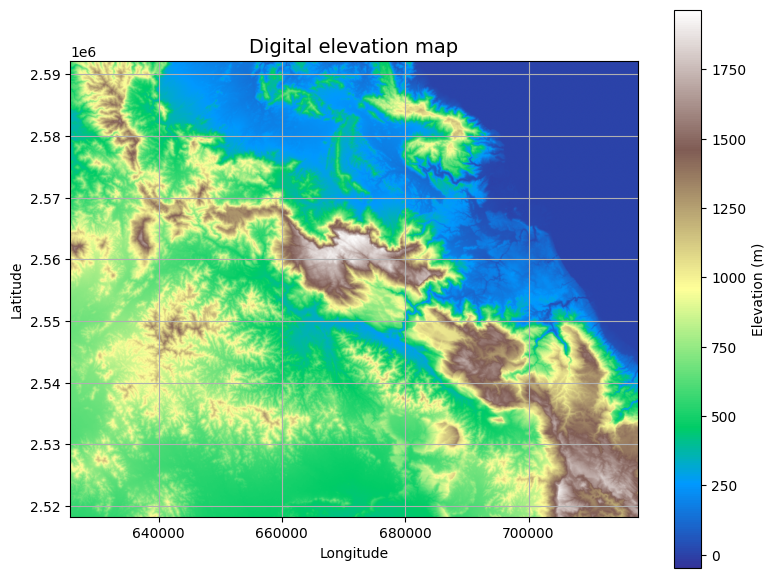

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

TypeError: can't unbox array from PyObject into native value.  The object maybe of a different type

In [ ]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

TypeError: `nodata` value not representable in dtype of array.

In [ ]:
# fig = plt.figure(figsize=(8,6))
# fig.patch.set_alpha(0)

# plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
# boundaries = ([0] + sorted(list(dirmap)))
# plt.colorbar(boundaries= boundaries,
#              values=sorted(dirmap))
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Flow direction grid', size=14)
# plt.grid(zorder=-1)
# plt.tight_layout()

: 

In [ ]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

: 

In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_alpha(0)
# plt.grid('on', zorder=0)
# im = ax.imshow(acc, extent=grid.extent, zorder=2,
#                cmap='cubehelix',
#                norm=colors.LogNorm(1, acc.max()),
#                interpolation='bilinear')
# plt.colorbar(im, ax=ax, label='Upstream Cells')
# plt.title('Flow Accumulation', size=14)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.tight_layout()

: 

In [ ]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = 689359.606, 2553949.326

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 3000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)


: 

In [ ]:
# Get cell size in meters from the affine transform
cell_size = abs(grid.affine[0] * grid.affine[4])  # cell dimensions in m²

# Count cells in catchment and convert to km²
catch_area = np.sum(clipped_catch) * cell_size / 1000000  # converts m² to km²

print(f"Catchment area: {catch_area:.2f} km²")


Catchment area: 1720.05 km²


: 

In [ ]:
# # Plot the catchment
# fig, ax = plt.subplots(figsize=(16,10))
# fig.patch.set_alpha(0)

# plt.grid('on', zorder=0)
# im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
#                zorder=1, cmap='Greys_r')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Delineated Catchment', size=14)

: 

In [ ]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 7000, dirmap=dirmap)

: 

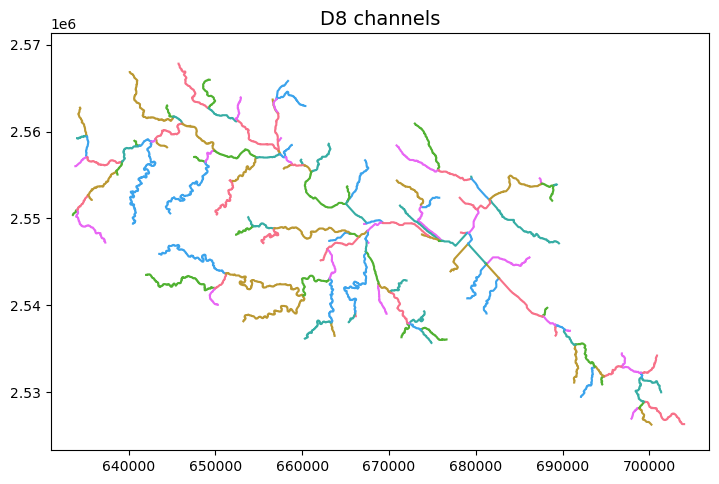

: 

: 

In [ ]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    plt.title('D8 channels', size=14)

In [ ]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir,
                               xytype='coordinate')


: 